# Deep Learning for Portfolio Optimization

Implementation of the methodology from:
**"Deep Learning for Portfolio Optimization"** by Zhang, Zohren, and Roberts (Oxford-Man Institute)

This notebook implements an end-to-end deep learning framework that directly optimizes the portfolio Sharpe ratio using LSTM networks.

## Model Assumptions, Strengths, and Weaknesses

### Key Model Assumptions

1. **Long-only portfolio constraint**: Weights are constrained to be positive and sum to 1 (via softmax output)
2. **No leverage**: The model does not allow for leveraged positions
3. **Perfect liquidity**: Assets can be traded at closing prices without market impact
4. **Transaction costs are linear**: Costs are proportional to traded value
5. **Returns are NOT assumed Gaussian**: Unlike MPT, this framework doesn't assume normal distributions
6. **Stationarity within training window**: The model assumes patterns learned in training persist in testing
7. **Daily rebalancing**: Portfolio weights can be adjusted daily
8. **Risk-free rate = 0**: Simplified Sharpe ratio without risk-free rate subtraction
9. **Ex-ante volatility estimation**: Uses exponentially weighted moving standard deviation (50-day window)

### Strengths

1. **End-to-end optimization**: Directly optimizes Sharpe ratio instead of intermediate objectives (return prediction)
2. **No explicit return forecasting**: Bypasses the difficult task of predicting expected returns
3. **Handles non-linear relationships**: Neural networks can capture complex market dynamics
4. **Feature extraction**: LSTM automatically learns relevant temporal patterns from raw price/return data
5. **Robust to fat tails**: Doesn't assume Gaussian returns, better handles extreme events
6. **Volatility scaling**: Can target specific risk levels, making comparisons fair
7. **Diversification through uncorrelated assets**: Uses ETFs of different asset classes
8. **Crisis adaptation**: Model showed reasonable behavior during COVID-19 crisis
9. **Flexible framework**: Can be extended to optimize Sortino ratio or other differentiable objectives

### Weaknesses

1. **High transaction costs**: Daily rebalancing generates significant turnover costs
2. **Requires substantial data**: Deep learning needs long historical periods for training
3. **Overfitting risk**: Neural networks can memorize noise, especially with limited data
4. **Black box nature**: Difficult to interpret why model makes specific allocation decisions
5. **Regime changes**: Model may struggle with unprecedented market regimes not seen in training
6. **Computational cost**: Training requires more resources than traditional methods
7. **Hyperparameter sensitivity**: Performance depends on network architecture, lookback window, etc.
8. **Look-ahead bias risk**: Must be careful with data preprocessing to avoid information leakage
9. **Limited to differentiable objectives**: Cannot directly optimize non-differentiable risk metrics
10. **Periodic retraining needed**: Model requires retraining (every 2 years in paper) to adapt to changing markets

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Collection

We'll use ETFs similar to the paper:
- **SPY**: S&P 500 ETF (stocks)
- **AGG**: US Aggregate Bond ETF (bonds)
- **DBC**: Commodities ETF
- **GLD**: Gold ETF (alternative to VIX for stability)

In [2]:
def download_data(tickers, start_date, end_date):
    """
    Download historical price data from Yahoo Finance.
    
    Parameters:
    -----------
    tickers : list
        List of ticker symbols
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    
    Returns:
    --------
    pd.DataFrame : DataFrame with adjusted close prices
    """
    data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
    prices = data['Close']
    
    # Handle single ticker case
    if isinstance(prices, pd.Series):
        prices = prices.to_frame(name=tickers[0])
    
    # Ensure column order matches ticker order
    prices = prices[tickers]
    
    return prices

# Define tickers and date range (past 10 years)
tickers = ['SPY', 'AGG', 'DBC', 'GLD']
asset_names = ['S&P 500', 'Bonds', 'Commodities', 'Gold']

end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')

print(f"Downloading data from {start_date} to {end_date}")
prices = download_data(tickers, start_date, end_date)

# Remove any rows with missing data
prices = prices.dropna()

print(f"\nData shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
prices.head()


Data shape: (2513, 4)
Date range: 2016-02-03 00:00:00 to 2026-01-30 00:00:00


Ticker,SPY,AGG,DBC,GLD
Date,,,,
2016-02-03,162.134125,83.299942,10.677876,109.250000
2016-02-04,162.388382,83.383774,10.660968,110.570000
2016-02-05,159.294876,83.307587,10.593332,112.320000
2016-02-08,157.150589,83.627640,10.542607,113.830002
2016-02-09,157.159073,83.620003,10.272067,113.580002


In [3]:
# Calculate daily returns
returns = prices.pct_change().dropna()

# Display basic statistics
print("Return Statistics (Annualized):")
print("="*50)
stats = pd.DataFrame({
    'Mean Return': returns.mean() * 252,
    'Volatility': returns.std() * np.sqrt(252),
    'Sharpe Ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252))
})
stats.index = asset_names
print(stats.round(4))

Return Statistics (Annualized):
             Mean Return  Volatility  Sharpe Ratio
S&P 500           0.1617      0.1791        0.9029
Bonds             0.0199      0.0537        0.3706
Commodities       0.0985      0.1753        0.5618
Gold              0.1527      0.1530        0.9980


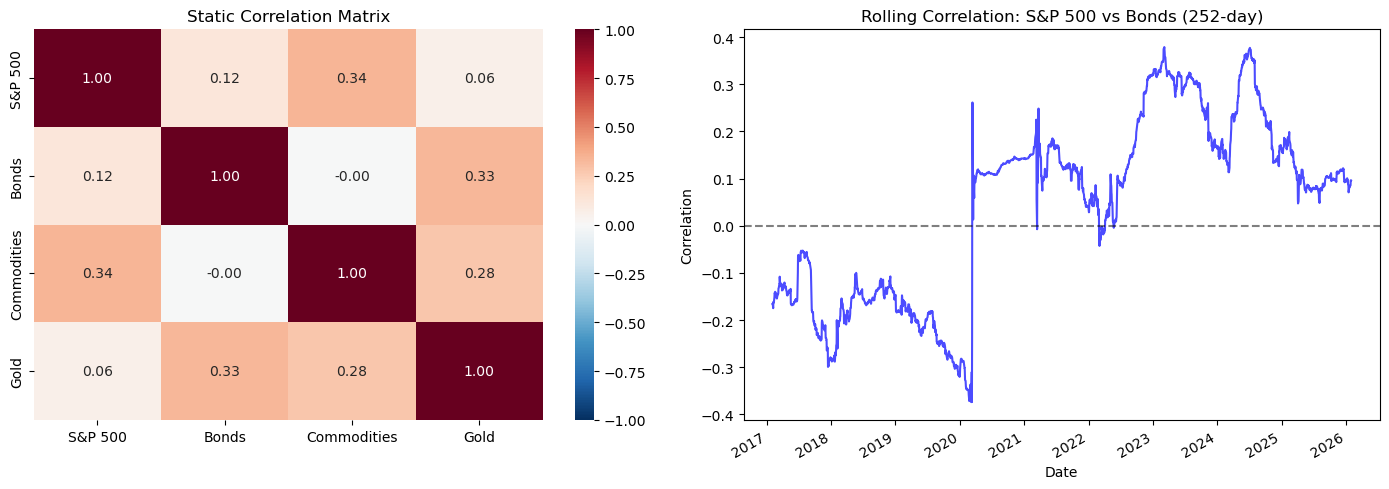

In [4]:
# Plot correlation heatmap (similar to Figure 1 in the paper)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Static correlation
corr_matrix = returns.corr()
corr_matrix.index = asset_names
corr_matrix.columns = asset_names

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[0], fmt='.2f')
axes[0].set_title('Static Correlation Matrix', fontsize=12)

# Rolling correlation (252-day window)
rolling_window = 252
rolling_corr = returns['SPY'].rolling(rolling_window).corr(returns['AGG'])
rolling_corr.plot(ax=axes[1], color='blue', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Rolling Correlation: S&P 500 vs Bonds (252-day)', fontsize=12)
axes[1].set_ylabel('Correlation')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 2. Data Preprocessing

Following the paper's methodology:
- Use past 50 days of prices and returns as features
- Normalize features for stable training
- Create sliding window dataset

In [5]:
class PortfolioDataset(Dataset):
    """
    PyTorch Dataset for portfolio optimization.
    
    Creates sequences of (prices, returns) for each asset over a lookback window.
    """
    
    def __init__(self, prices, returns, lookback=50):
        """
        Parameters:
        -----------
        prices : pd.DataFrame
            DataFrame of asset prices
        returns : pd.DataFrame
            DataFrame of asset returns
        lookback : int
            Number of historical days to use as features
        """
        self.lookback = lookback
        self.n_assets = len(prices.columns)
        
        # Normalize prices (z-score normalization per asset)
        self.prices_norm = (prices - prices.rolling(lookback).mean()) / prices.rolling(lookback).std()
        self.prices_norm = self.prices_norm.dropna()
        
        # Align returns with normalized prices
        self.returns = returns.loc[self.prices_norm.index]
        
        # Convert to numpy
        self.prices_arr = self.prices_norm.values
        self.returns_arr = self.returns.values
        
        # Number of valid samples
        self.n_samples = len(self.prices_arr) - lookback
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """
        Returns:
        --------
        features : tensor of shape (lookback, n_assets * 2)
            Concatenated prices and returns for all assets
        next_returns : tensor of shape (n_assets,)
            Returns for the next day (used for computing portfolio return)
        """
        # Get lookback window
        price_window = self.prices_arr[idx:idx+self.lookback]
        return_window = self.returns_arr[idx:idx+self.lookback]
        
        # Concatenate prices and returns as features
        features = np.concatenate([price_window, return_window], axis=1)
        
        # Next day's returns (for computing realized portfolio return)
        next_returns = self.returns_arr[idx + self.lookback]
        
        return (
            torch.FloatTensor(features),
            torch.FloatTensor(next_returns)
        )

# Create dataset
lookback = 50
dataset = PortfolioDataset(prices, returns, lookback=lookback)
print(f"Total samples: {len(dataset)}")
print(f"Feature shape per sample: ({lookback}, {len(tickers) * 2})")

Total samples: 2414
Feature shape per sample: (50, 8)


## 3. Model Architecture

Following the paper (Section 3.2):
- **Input Layer**: Concatenated price and return features
- **Neural Layer**: Single LSTM with 64 units
- **Output Layer**: Softmax for long-only portfolio weights

In [6]:
class PortfolioLSTM(nn.Module):
    """
    LSTM-based portfolio optimization model.
    
    Architecture follows the paper:
    - Input: (batch, seq_len, n_features)
    - LSTM: Single layer with 64 hidden units
    - Output: Softmax weights for each asset
    """
    
    def __init__(self, n_features, n_assets, hidden_size=64, dropout=0.1):
        super(PortfolioLSTM, self).__init__()
        
        self.n_assets = n_assets
        self.hidden_size = hidden_size
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Output layer (raw weights before softmax)
        self.fc = nn.Linear(hidden_size, n_assets)
        
    def forward(self, x):
        """
        Forward pass.
        
        Parameters:
        -----------
        x : tensor of shape (batch, seq_len, n_features)
        
        Returns:
        --------
        weights : tensor of shape (batch, n_assets)
            Portfolio weights (sum to 1, all positive)
        """
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use the last hidden state
        last_hidden = lstm_out[:, -1, :]
        
        # Apply dropout
        last_hidden = self.dropout(last_hidden)
        
        # Get raw weights
        raw_weights = self.fc(last_hidden)
        
        # Apply softmax to get valid portfolio weights (Equation 5)
        weights = torch.softmax(raw_weights, dim=1)
        
        return weights

# Initialize model
n_features = len(tickers) * 2  # prices + returns for each asset
n_assets = len(tickers)

model = PortfolioLSTM(n_features, n_assets, hidden_size=64, dropout=0.1).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

PortfolioLSTM(
  (lstm): LSTM(8, 64, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

Total parameters: 19,204


## 4. Sharpe Ratio Loss Function

The key innovation: directly optimize Sharpe ratio (Equation 2)

In [7]:
def compute_sharpe_ratio(portfolio_returns, annualization_factor=252):
    """
    Compute Sharpe ratio from a series of portfolio returns.
    
    Sharpe = E(R_p) / Std(R_p) (Equation 1)
    
    Parameters:
    -----------
    portfolio_returns : tensor of shape (T,)
        Daily portfolio returns
    annualization_factor : int
        Factor to annualize (252 for daily data)
    
    Returns:
    --------
    sharpe : scalar tensor
        Sharpe ratio (annualized)
    """
    mean_return = portfolio_returns.mean()
    std_return = portfolio_returns.std()
    
    # Avoid division by zero
    std_return = torch.clamp(std_return, min=1e-8)
    
    # Annualized Sharpe ratio
    sharpe = (mean_return / std_return) * np.sqrt(annualization_factor)
    
    return sharpe


def compute_portfolio_returns(weights, asset_returns):
    """
    Compute realized portfolio returns (Equation 3).
    
    R_p,t = sum_i (w_i,t-1 * r_i,t)
    
    Parameters:
    -----------
    weights : tensor of shape (T, n_assets)
        Portfolio weights at each time step
    asset_returns : tensor of shape (T, n_assets)
        Asset returns at each time step
    
    Returns:
    --------
    portfolio_returns : tensor of shape (T,)
        Daily portfolio returns
    """
    # Element-wise multiplication and sum across assets
    portfolio_returns = (weights * asset_returns).sum(dim=1)
    return portfolio_returns


def sharpe_loss(weights, asset_returns, cost_rate=0.0001):
    """
    Compute negative Sharpe ratio (for minimization) with transaction costs.
    
    Parameters:
    -----------
    weights : tensor of shape (T, n_assets)
        Portfolio weights
    asset_returns : tensor of shape (T, n_assets)
        Next-day asset returns
    cost_rate : float
        Transaction cost rate (default 1bp = 0.0001)
    
    Returns:
    --------
    loss : scalar tensor
        Negative Sharpe ratio
    """
    # Compute portfolio returns
    portfolio_returns = compute_portfolio_returns(weights, asset_returns)
    
    # Compute transaction costs (based on weight changes)
    if weights.shape[0] > 1:
        weight_changes = torch.abs(weights[1:] - weights[:-1])
        transaction_costs = cost_rate * weight_changes.sum(dim=1)
        # Pad with zero for first day
        transaction_costs = torch.cat([torch.zeros(1, device=weights.device), transaction_costs])
        portfolio_returns = portfolio_returns - transaction_costs
    
    # Compute Sharpe ratio
    sharpe = compute_sharpe_ratio(portfolio_returns)
    
    # Return negative for minimization
    return -sharpe

## 5. Training Loop

Following the paper:
- Adam optimizer
- Mini-batch size of 64 (we process sequences, so we use full batches for Sharpe computation)
- 10% validation split
- Maximum 100 epochs

In [8]:
def train_model(model, train_features, train_returns, val_features, val_returns,
                n_epochs=100, lr=0.001, cost_rate=0.0001, patience=10):
    """
    Train the portfolio optimization model.
    
    Parameters:
    -----------
    model : PortfolioLSTM
        The model to train
    train_features : tensor of shape (T_train, lookback, n_features)
        Training feature sequences
    train_returns : tensor of shape (T_train, n_assets)
        Training next-day returns
    val_features : tensor of shape (T_val, lookback, n_features)
        Validation feature sequences
    val_returns : tensor of shape (T_val, n_assets)
        Validation next-day returns
    n_epochs : int
        Maximum number of training epochs
    lr : float
        Learning rate
    cost_rate : float
        Transaction cost rate
    patience : int
        Early stopping patience
    
    Returns:
    --------
    train_history : list
        Training Sharpe ratios per epoch
    val_history : list
        Validation Sharpe ratios per epoch
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_history = []
    val_history = []
    best_val_sharpe = -np.inf
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass on all training data
        train_weights = model(train_features)
        train_loss = sharpe_loss(train_weights, train_returns, cost_rate)
        
        # Backward pass
        train_loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_weights = model(val_features)
            val_loss = sharpe_loss(val_weights, val_returns, cost_rate)
        
        train_sharpe = -train_loss.item()
        val_sharpe = -val_loss.item()
        
        train_history.append(train_sharpe)
        val_history.append(val_sharpe)
        
        # Early stopping
        if val_sharpe > best_val_sharpe:
            best_val_sharpe = val_sharpe
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d} | Train Sharpe: {train_sharpe:.4f} | Val Sharpe: {val_sharpe:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_history, val_history

In [9]:
# Prepare data for training
# Split: first 70% train, next 10% validation, last 20% test

n_samples = len(dataset)
train_end = int(n_samples * 0.7)
val_end = int(n_samples * 0.8)

# Collect all samples
all_features = []
all_returns = []

for i in range(n_samples):
    feat, ret = dataset[i]
    all_features.append(feat)
    all_returns.append(ret)

all_features = torch.stack(all_features).to(device)
all_returns = torch.stack(all_returns).to(device)

# Split data
train_features = all_features[:train_end]
train_returns = all_returns[:train_end]

val_features = all_features[train_end:val_end]
val_returns = all_returns[train_end:val_end]

test_features = all_features[val_end:]
test_returns = all_returns[val_end:]

print(f"Training samples: {len(train_features)}")
print(f"Validation samples: {len(val_features)}")
print(f"Test samples: {len(test_features)}")

Training samples: 1689
Validation samples: 242
Test samples: 483


In [10]:
# Train the model
model = PortfolioLSTM(n_features, n_assets, hidden_size=64, dropout=0.1).to(device)

print("Training Deep Learning Portfolio Model...")
print("="*50)

train_history, val_history = train_model(
    model, train_features, train_returns,
    val_features, val_returns,
    n_epochs=100, lr=0.001, cost_rate=0.0001, patience=15
)

Training Deep Learning Portfolio Model...
Epoch  10 | Train Sharpe: 0.8320 | Val Sharpe: 1.5672
Epoch  20 | Train Sharpe: 0.9568 | Val Sharpe: 1.6138
Epoch  30 | Train Sharpe: 1.1601 | Val Sharpe: 1.6380
Epoch  40 | Train Sharpe: 1.3771 | Val Sharpe: 1.4544
Early stopping at epoch 43


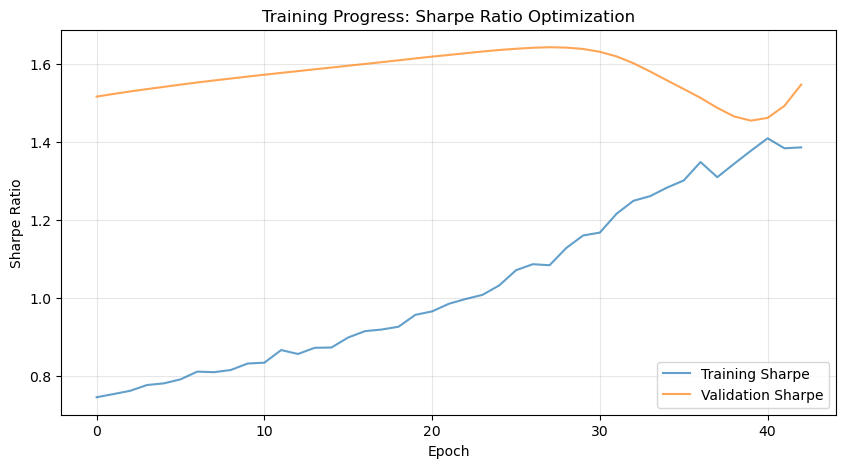

In [11]:
# Plot training history
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_history, label='Training Sharpe', alpha=0.7)
ax.plot(val_history, label='Validation Sharpe', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Training Progress: Sharpe Ratio Optimization')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 6. Baseline Strategies

Implementing comparison strategies from the paper:

In [12]:
def equal_weight_strategy(n_assets, n_days):
    """Equal weight (1/N) portfolio - similar to Allocation 1."""
    return np.ones((n_days, n_assets)) / n_assets

def sixty_forty_strategy(n_days):
    """60/40 stocks/bonds - classic allocation (similar to Allocation 4)."""
    weights = np.zeros((n_days, 4))
    weights[:, 0] = 0.60  # Stocks
    weights[:, 1] = 0.40  # Bonds
    weights[:, 2] = 0.00  # Commodities
    weights[:, 3] = 0.00  # Gold
    return weights

def risk_parity_strategy(returns_df, lookback=50):
    """
    Risk parity: weight inversely proportional to volatility.
    Similar to volatility scaling concept in the paper.
    """
    n_days = len(returns_df) - lookback
    n_assets = len(returns_df.columns)
    weights = np.zeros((n_days, n_assets))
    
    for t in range(n_days):
        # Rolling volatility
        vol = returns_df.iloc[t:t+lookback].std().values
        inv_vol = 1 / (vol + 1e-8)
        weights[t] = inv_vol / inv_vol.sum()
    
    return weights

def mean_variance_strategy(returns_df, lookback=50):
    """
    Mean-variance optimization (simplified - maximize Sharpe with long-only constraint).
    """
    from scipy.optimize import minimize
    
    n_days = len(returns_df) - lookback
    n_assets = len(returns_df.columns)
    weights = np.zeros((n_days, n_assets))
    
    for t in range(n_days):
        hist_returns = returns_df.iloc[t:t+lookback].values
        mean_ret = hist_returns.mean(axis=0)
        cov_matrix = np.cov(hist_returns.T)
        
        # Objective: negative Sharpe
        def neg_sharpe(w):
            port_ret = np.dot(w, mean_ret)
            port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
            return -port_ret / (port_vol + 1e-8)
        
        # Constraints: weights sum to 1
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1) for _ in range(n_assets)]
        
        # Initial guess: equal weight
        w0 = np.ones(n_assets) / n_assets
        
        result = minimize(neg_sharpe, w0, method='SLSQP', 
                         bounds=bounds, constraints=constraints)
        
        weights[t] = result.x if result.success else w0
    
    return weights

print("Baseline strategies defined.")

Baseline strategies defined.


## 7. Backtesting & Performance Evaluation

In [13]:
def backtest_strategy(weights, returns_array, cost_rate=0.0001):
    """
    Backtest a portfolio strategy.
    
    Parameters:
    -----------
    weights : np.array of shape (T, n_assets)
        Portfolio weights
    returns_array : np.array of shape (T, n_assets)
        Asset returns
    cost_rate : float
        Transaction cost rate
    
    Returns:
    --------
    dict : Dictionary with performance metrics
    """
    # Portfolio returns
    port_returns = (weights * returns_array).sum(axis=1)
    
    # Transaction costs
    weight_changes = np.abs(np.diff(weights, axis=0)).sum(axis=1)
    costs = np.concatenate([[0], weight_changes * cost_rate])
    port_returns_net = port_returns - costs
    
    # Cumulative returns
    cum_returns = np.cumprod(1 + port_returns_net) - 1
    
    # Performance metrics
    ann_return = port_returns_net.mean() * 252
    ann_vol = port_returns_net.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Downside deviation and Sortino
    downside_returns = port_returns_net[port_returns_net < 0]
    downside_dev = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 1e-8
    sortino = ann_return / downside_dev
    
    # Maximum drawdown
    cum_wealth = np.cumprod(1 + port_returns_net)
    running_max = np.maximum.accumulate(cum_wealth)
    drawdown = (cum_wealth - running_max) / running_max
    max_dd = np.min(drawdown)
    
    # Percentage of positive returns
    pct_positive = (port_returns_net > 0).mean()
    
    # Average gain / Average loss ratio
    gains = port_returns_net[port_returns_net > 0]
    losses = port_returns_net[port_returns_net < 0]
    avg_gain_loss = (gains.mean() / abs(losses.mean())) if len(losses) > 0 and losses.mean() != 0 else np.inf
    
    # Turnover
    turnover = weight_changes.mean() * 252  # Annualized
    
    return {
        'Annual Return': ann_return,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd,
        '% Positive Days': pct_positive,
        'Avg Gain/Loss': avg_gain_loss,
        'Annual Turnover': turnover,
        'Cumulative Returns': cum_returns,
        'Daily Returns': port_returns_net,
        'Weights': weights
    }

In [14]:
# Get DLS model predictions on test set
model.eval()
with torch.no_grad():
    dls_weights = model(test_features).cpu().numpy()

test_returns_np = test_returns.cpu().numpy()
n_test_days = len(test_returns_np)

# Get returns dataframe for test period (for baseline strategies)
test_start_idx = val_end + lookback
test_returns_df = returns.iloc[test_start_idx:test_start_idx + n_test_days]

# Compute baseline weights
print("Computing baseline strategy weights...")

ew_weights = equal_weight_strategy(n_assets, n_test_days)
sf_weights = sixty_forty_strategy(n_test_days)

# For risk parity and MV, we need more historical data
extended_returns_df = returns.iloc[test_start_idx - lookback:test_start_idx + n_test_days]
rp_weights = risk_parity_strategy(extended_returns_df, lookback=lookback)

print("Computing Mean-Variance weights (this may take a moment)...")
mv_weights = mean_variance_strategy(extended_returns_df, lookback=lookback)

print("Done!")

Computing baseline strategy weights...
Computing Mean-Variance weights (this may take a moment)...
Done!


In [15]:
# Backtest all strategies
cost_rate = 0.0001  # 1 basis point

strategies = {
    'DLS (Ours)': dls_weights,
    'Equal Weight': ew_weights,
    '60/40 Stocks/Bonds': sf_weights,
    'Risk Parity': rp_weights,
    'Mean-Variance': mv_weights
}

results = {}
for name, weights in strategies.items():
    results[name] = backtest_strategy(weights, test_returns_np, cost_rate)

In [16]:
# Create performance summary table (similar to Table 1 in the paper)
summary_data = []
for name, res in results.items():
    summary_data.append({
        'Strategy': name,
        'E(R)': f"{res['Annual Return']:.3f}",
        'Std(R)': f"{res['Annual Volatility']:.3f}",
        'Sharpe': f"{res['Sharpe Ratio']:.3f}",
        'Sortino': f"{res['Sortino Ratio']:.3f}",
        'MDD': f"{res['Max Drawdown']:.3f}",
        '% Positive': f"{res['% Positive Days']:.3f}",
        'Turnover': f"{res['Annual Turnover']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Strategy')

print("\n" + "="*80)
print("PERFORMANCE SUMMARY (Test Period)")
print(f"Cost Rate: {cost_rate*10000:.1f} bps")
print("="*80)
print(summary_df.to_string())
print("="*80)


PERFORMANCE SUMMARY (Test Period)
Cost Rate: 1.0 bps
                     E(R) Std(R) Sharpe Sortino     MDD % Positive Turnover
Strategy                                                                   
DLS (Ours)          0.216  0.100  2.157   3.080  -0.068      0.596     9.97
Equal Weight        0.206  0.094  2.187   2.821  -0.074      0.600     0.00
60/40 Stocks/Bonds  0.136  0.103  1.318   1.734  -0.113      0.561     0.00
Risk Parity         0.141  0.069  2.046   2.863  -0.055      0.590     3.17
Mean-Variance       0.079  0.114  0.698   0.809  -0.174      0.565    43.92


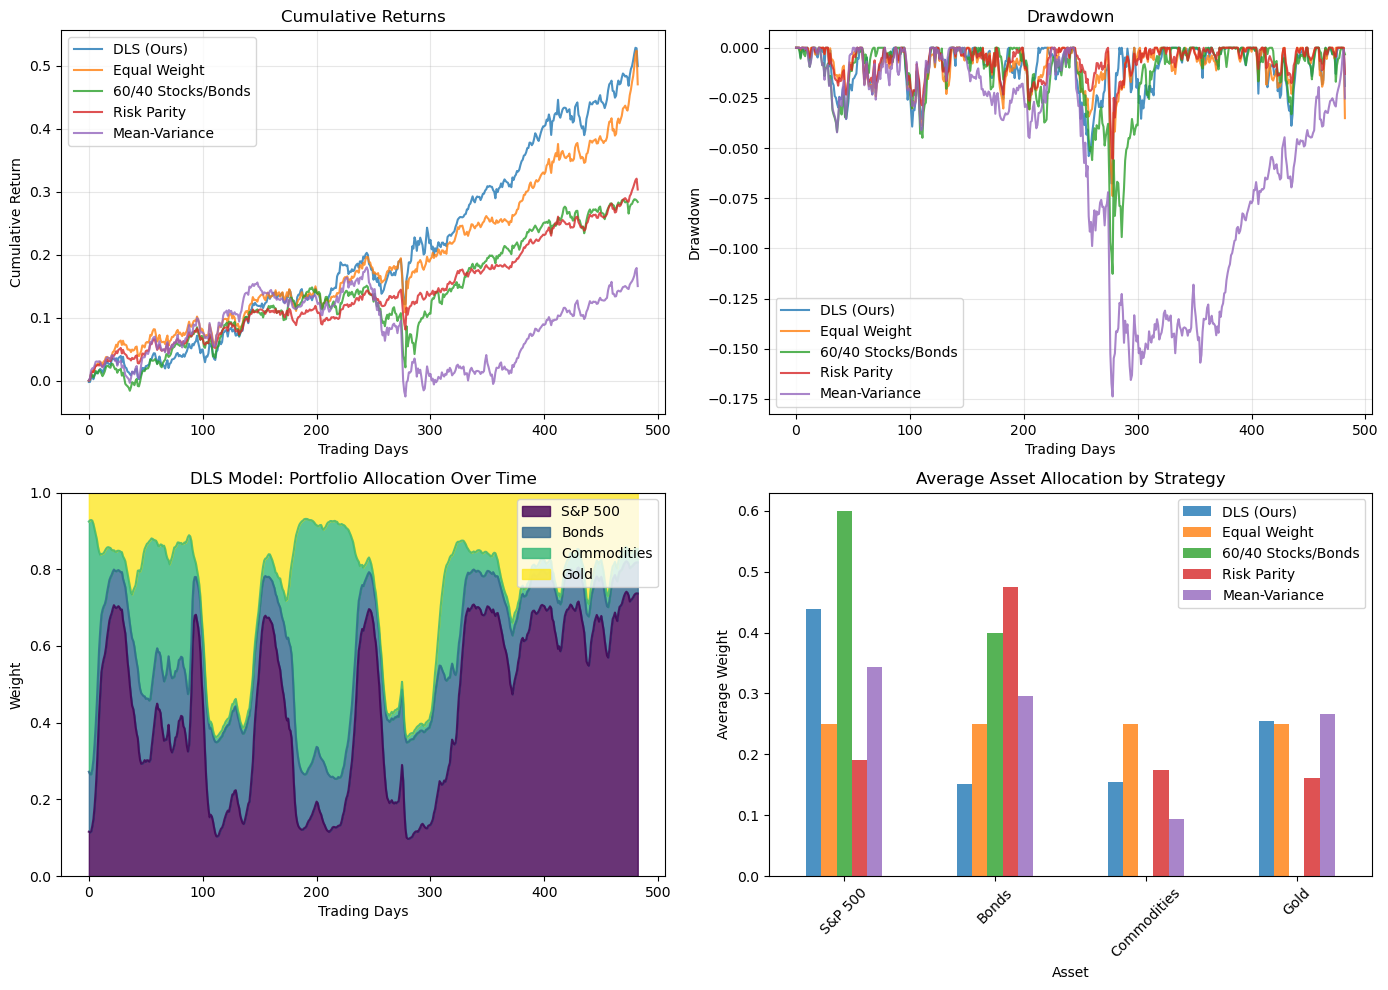

In [17]:
# Plot cumulative returns (similar to Figure 3 in the paper)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
for name, res in results.items():
    ax1.plot(res['Cumulative Returns'], label=name, alpha=0.8)
ax1.set_title('Cumulative Returns', fontsize=12)
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Drawdown comparison
ax2 = axes[0, 1]
for name, res in results.items():
    cum_wealth = np.cumprod(1 + res['Daily Returns'])
    running_max = np.maximum.accumulate(cum_wealth)
    drawdown = (cum_wealth - running_max) / running_max
    ax2.plot(drawdown, label=name, alpha=0.8)
ax2.set_title('Drawdown', fontsize=12)
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Drawdown')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

# DLS weight allocation over time (similar to Figure 5)
ax3 = axes[1, 0]
dls_weights_df = pd.DataFrame(dls_weights, columns=asset_names)
dls_weights_df.plot.area(ax=ax3, alpha=0.8, colormap='viridis')
ax3.set_title('DLS Model: Portfolio Allocation Over Time', fontsize=12)
ax3.set_xlabel('Trading Days')
ax3.set_ylabel('Weight')
ax3.legend(loc='upper right')
ax3.set_ylim(0, 1)

# Average allocation comparison
ax4 = axes[1, 1]
avg_weights = pd.DataFrame({name: res['Weights'].mean(axis=0) for name, res in results.items()},
                           index=asset_names)
avg_weights.plot(kind='bar', ax=ax4, alpha=0.8)
ax4.set_title('Average Asset Allocation by Strategy', fontsize=12)
ax4.set_xlabel('Asset')
ax4.set_ylabel('Average Weight')
ax4.legend(loc='upper right')
ax4.set_xticklabels(asset_names, rotation=45)

plt.tight_layout()
plt.show()

## 8. Volatility Scaling Analysis

Following Equation 7 in the paper: scale positions to target a specific volatility level.

In [18]:
def apply_volatility_scaling(weights, returns_array, sigma_target=0.10, lookback=50):
    """
    Apply volatility scaling to portfolio positions (Equation 7).
    
    Parameters:
    -----------
    weights : np.array of shape (T, n_assets)
        Raw portfolio weights
    returns_array : np.array of shape (T, n_assets)
        Asset returns
    sigma_target : float
        Target annualized volatility
    lookback : int
        Lookback for volatility estimation
    
    Returns:
    --------
    scaled_weights : np.array
        Volatility-scaled weights
    """
    T, n_assets = weights.shape
    scaled_weights = np.zeros_like(weights)
    
    # Convert target to daily
    daily_target = sigma_target / np.sqrt(252)
    
    for t in range(T):
        if t < lookback:
            # Not enough history, use unscaled
            scaled_weights[t] = weights[t]
        else:
            # Exponentially weighted volatility
            alpha = 2 / (lookback + 1)
            hist_returns = returns_array[max(0, t-lookback):t]
            
            for i in range(n_assets):
                asset_vol = np.std(hist_returns[:, i])
                scaling_factor = daily_target / (asset_vol + 1e-8)
                scaling_factor = np.clip(scaling_factor, 0.1, 5)  # Limit leverage
                scaled_weights[t, i] = weights[t, i] * scaling_factor
            
            # Renormalize to sum to 1
            scaled_weights[t] = scaled_weights[t] / scaled_weights[t].sum()
    
    return scaled_weights

# Apply volatility scaling
sigma_target = 0.10  # 10% annualized volatility target

results_scaled = {}
for name, weights in strategies.items():
    scaled_weights = apply_volatility_scaling(weights, test_returns_np, sigma_target)
    results_scaled[name] = backtest_strategy(scaled_weights, test_returns_np, cost_rate)

# Summary with volatility scaling
print("\n" + "="*80)
print(f"PERFORMANCE WITH VOLATILITY SCALING (Target σ = {sigma_target*100:.0f}%)")
print("="*80)

summary_scaled = []
for name, res in results_scaled.items():
    summary_scaled.append({
        'Strategy': name,
        'E(R)': f"{res['Annual Return']:.3f}",
        'Std(R)': f"{res['Annual Volatility']:.3f}",
        'Sharpe': f"{res['Sharpe Ratio']:.3f}",
        'Sortino': f"{res['Sortino Ratio']:.3f}",
        'MDD': f"{res['Max Drawdown']:.3f}"
    })

summary_scaled_df = pd.DataFrame(summary_scaled).set_index('Strategy')
print(summary_scaled_df.to_string())


PERFORMANCE WITH VOLATILITY SCALING (Target σ = 10%)
                     E(R) Std(R) Sharpe Sortino     MDD
Strategy                                               
DLS (Ours)          0.170  0.079  2.143   3.083  -0.049
Equal Weight        0.150  0.065  2.299   3.216  -0.052
60/40 Stocks/Bonds  0.093  0.066  1.416   1.974  -0.061
Risk Parity         0.100  0.050  1.985   2.831  -0.034
Mean-Variance       0.052  0.102  0.512   0.570  -0.183


## 9. Sensitivity Analysis

Following Section 4.6: analyze which input features are most important.

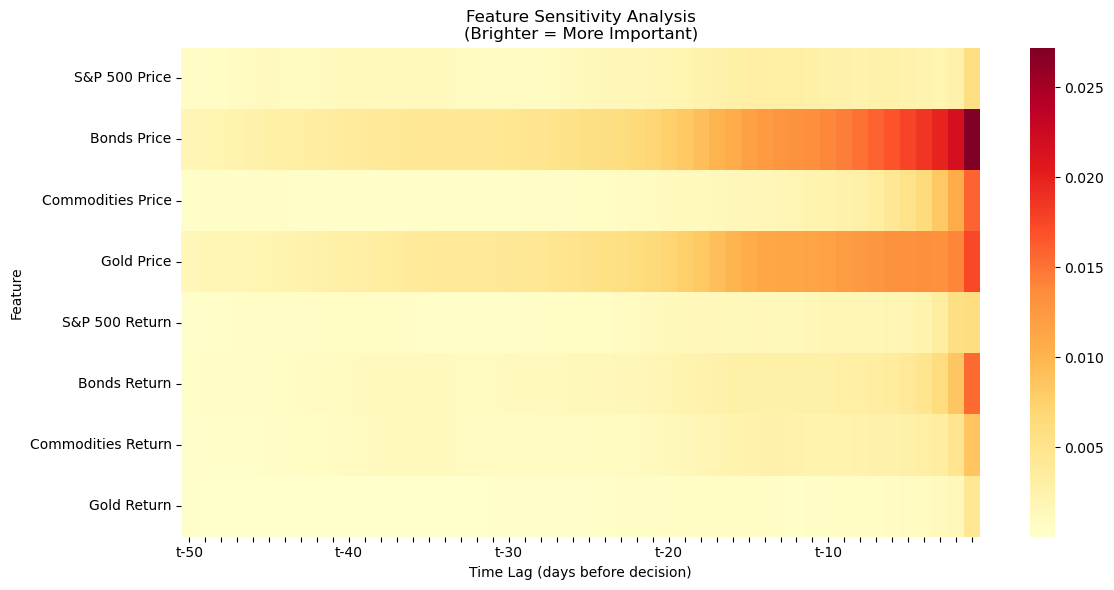


Average Sensitivity by Feature (most recent 10 days):
  S&P 500 Price: 0.0029
  Bonds Price: 0.0181
  Commodities Price: 0.0063
  Gold Price: 0.0133
  S&P 500 Return: 0.0029
  Bonds Return: 0.0056
  Commodities Return: 0.0036
  Gold Return: 0.0013


In [19]:
def compute_sensitivity(model, features, epsilon=1e-4):
    """
    Compute sensitivity of outputs to input features (Equation 8).
    Uses autograd to compute dL/dx_i.
    
    NOTE: We must keep the model in train() mode because cuDNN's
    LSTM backward pass does not support eval() mode. To get clean
    gradients we temporarily disable dropout instead.
    
    Parameters:
    -----------
    model : PortfolioLSTM
        Trained model
    features : tensor of shape (batch, seq_len, n_features)
        Input features
    epsilon : float
        Perturbation size
    
    Returns:
    --------
    sensitivity : np.array of shape (seq_len, n_features)
        Normalized sensitivity for each feature
    """
    # Keep model in train() mode (required by cuDNN LSTM backward),
    # but disable dropout so results are deterministic.
    model.train()
    original_dropout = model.dropout.p
    model.dropout.p = 0.0
    
    features = features.clone().detach().requires_grad_(True)
    
    # Forward pass
    weights = model(features)
    
    # Compute gradient with respect to inputs
    # Use sum of weights as scalar output
    loss = weights.sum()
    loss.backward()
    
    # Restore dropout
    model.dropout.p = original_dropout
    
    # Get gradients
    gradients = features.grad.cpu().numpy()
    
    # Average over batch
    avg_grad = np.mean(np.abs(gradients), axis=0)
    
    # Normalize (Equation 8)
    max_grad = np.max(avg_grad)
    sensitivity = avg_grad / (max_grad + 1e-8)
    
    return sensitivity

# Compute sensitivity
sensitivity = compute_sensitivity(model, test_features[:100])  # Use subset for speed

# Plot sensitivity heatmap (similar to Figure 6)
fig, ax = plt.subplots(figsize=(12, 6))

# Feature names
feature_names = []
for asset in asset_names:
    feature_names.append(f"{asset} Price")
for asset in asset_names:
    feature_names.append(f"{asset} Return")

sns.heatmap(sensitivity.T, cmap='YlOrRd', ax=ax,
            yticklabels=feature_names,
            xticklabels=[f"t-{50-i}" if i % 10 == 0 else '' for i in range(50)])
ax.set_xlabel('Time Lag (days before decision)')
ax.set_ylabel('Feature')
ax.set_title('Feature Sensitivity Analysis\n(Brighter = More Important)', fontsize=12)
plt.tight_layout()
plt.show()

# Summary: average sensitivity by feature type
print("\nAverage Sensitivity by Feature (most recent 10 days):")
recent_sensitivity = sensitivity[-10:].mean(axis=0)
for i, name in enumerate(feature_names):
    print(f"  {name}: {recent_sensitivity[i]:.4f}")

## 10. Transaction Cost Sensitivity

Analyze performance under different cost rates (as shown in Table 1).

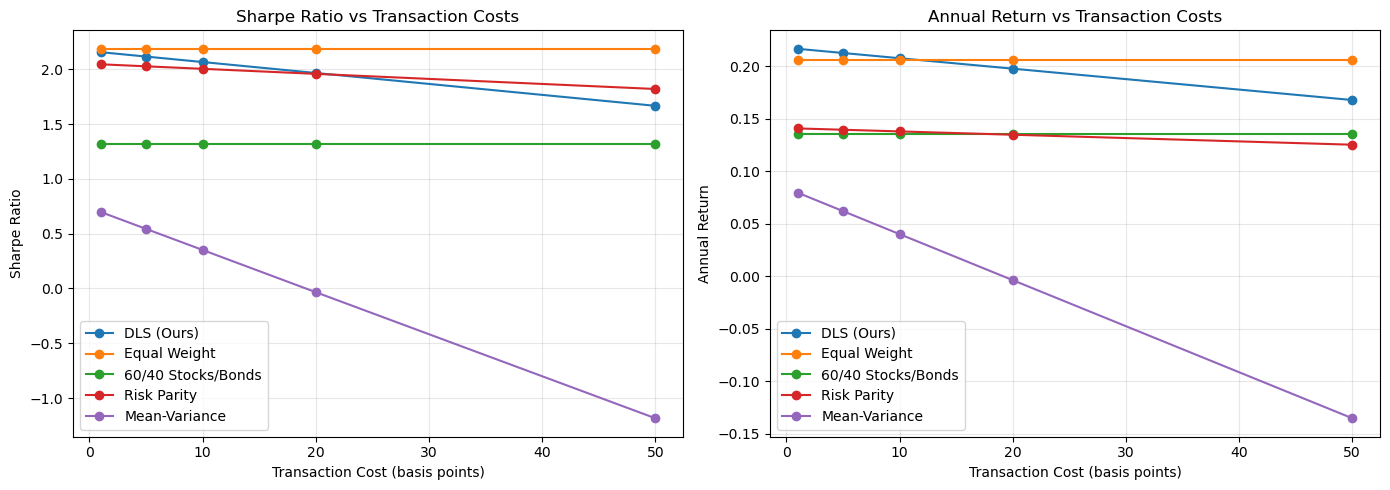

In [20]:
# Test different cost rates
cost_rates = [0.0001, 0.0005, 0.001, 0.002, 0.005]  # 1bp to 50bp

cost_analysis = []
for cr in cost_rates:
    for name, weights in strategies.items():
        res = backtest_strategy(weights, test_returns_np, cr)
        cost_analysis.append({
            'Cost Rate (bps)': cr * 10000,
            'Strategy': name,
            'Sharpe': res['Sharpe Ratio'],
            'Return': res['Annual Return']
        })

cost_df = pd.DataFrame(cost_analysis)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sharpe vs Cost Rate
for name in strategies.keys():
    subset = cost_df[cost_df['Strategy'] == name]
    axes[0].plot(subset['Cost Rate (bps)'], subset['Sharpe'], marker='o', label=name)
axes[0].set_xlabel('Transaction Cost (basis points)')
axes[0].set_ylabel('Sharpe Ratio')
axes[0].set_title('Sharpe Ratio vs Transaction Costs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Return vs Cost Rate
for name in strategies.keys():
    subset = cost_df[cost_df['Strategy'] == name]
    axes[1].plot(subset['Cost Rate (bps)'], subset['Return'], marker='o', label=name)
axes[1].set_xlabel('Transaction Cost (basis points)')
axes[1].set_ylabel('Annual Return')
axes[1].set_title('Annual Return vs Transaction Costs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Conclusions

This notebook implements the deep learning portfolio optimization methodology from Zhang, Zohren, and Roberts (2020).

### Key Takeaways:

1. **Direct Sharpe Optimization**: The LSTM model directly optimizes the Sharpe ratio through gradient ascent, bypassing the need for return forecasting.

2. **End-to-End Learning**: Features are automatically extracted by the neural network from raw price and return data.

3. **Transaction Cost Impact**: The DLS model generates higher turnover than simple allocation strategies, making it more sensitive to transaction costs.

4. **Volatility Scaling**: Applying volatility scaling helps normalize risk across strategies for fair comparison.

5. **Feature Importance**: Recent observations carry more weight in the model's decisions, consistent with financial intuition.

### Limitations of this Implementation:

- Simplified compared to the paper (single training period vs. rolling retraining)
- Uses different ETFs due to data availability
- No VIX (volatility index) included
- Smaller lookback window may be needed for current market conditions

In [21]:
# Final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nData Period: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(f"Test Period: {n_test_days} trading days")
print(f"Assets: {', '.join(asset_names)}")
print(f"\nBest Sharpe Ratio (without vol scaling): {max(results.items(), key=lambda x: x[1]['Sharpe Ratio'])[0]}")
print(f"Best Sharpe Ratio (with vol scaling): {max(results_scaled.items(), key=lambda x: x[1]['Sharpe Ratio'])[0]}")


FINAL SUMMARY

Data Period: 2016-02-03 to 2026-01-30
Test Period: 483 trading days
Assets: S&P 500, Bonds, Commodities, Gold

Best Sharpe Ratio (without vol scaling): Equal Weight
Best Sharpe Ratio (with vol scaling): Equal Weight
